## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [ ]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [ ]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
pre_path = '/data/ephemeral/home/train_lon_apt.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
dt_pre = pd.read_csv(pre_path)

In [ ]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape, 'preprocessed data shape : ', dt_pre.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51) preprocessed data shape :  (1128094, 55)


In [ ]:
display(dt_pre.head(1))

,Unnamed: 0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1


In [ ]:
dt_CLI = dt_pre[['시군구','번지','계약년월', '계약일', 'target', 'is_test']]
dt_CLI

,시군구,번지,계약년월,계약일,target,is_test
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0
...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1


In [ ]:
CLI = pd.read_csv('/data/ephemeral/home/CLI.csv')
CLI = CLI.rename(columns={'선행종합지수(2020=100)':'CLI'})
CLI = CLI.rename(columns={'시점':'계약년월'})
CLI

,계약년월,CLI
0,2007.01,62.3
1,2007.02,62.6
2,2007.03,62.8
3,2007.04,63.0
4,2007.05,63.2
...,...,...
196,2023.05,109.8
197,2023.06,110.5
198,2023.07,111.1
199,2023.08,111.4


In [ ]:
CLI['계약년월'] = CLI['계약년월']*100
CLI['계약년월'] = CLI['계약년월'].astype(int)
CLI

,계약년월,CLI
0,200701,62.3
1,200702,62.6
2,200703,62.8
3,200704,63.0
4,200705,63.2
...,...,...
196,202305,109.8
197,202306,110.5
198,202307,111.1
199,202308,111.4


In [ ]:
df_merged = pd.merge(dt_CLI, CLI, on='계약년월', how='left')
df_merged

,시군구,번지,계약년월,계약일,target,is_test,CLI
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,93.2
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,93.2
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,93.2
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,93.5
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,93.5
...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,111.1
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,111.4
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,111.8
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,111.1


In [ ]:
df_merged.to_csv('with_CLI.csv', index=False)

In [ ]:
# 'date'와 'is_test'가 0인 데이터만 선택
filtered_data = df_merged[df_merged['is_test'] == 0]

#filtered_data = filtered_data[df_merged['구'] == '강남구']

grouped_data = filtered_data.groupby('계약년월')

grouped_data = grouped_data.mean().reset_index()

grouped_data.reset_index(drop=True, inplace=True)

grouped_data.drop(columns=['계약일', 'is_test'], inplace=True)

grouped_data['계약년월'] = grouped_data['계약년월'].astype(str)

grouped_data

,계약년월,target,CLI
0,200701,27907.070115,62.3
1,200702,28687.696452,62.6
2,200703,26188.014682,62.8
3,200704,29135.020486,63.0
4,200705,32721.145273,63.2
...,...,...,...
193,202302,98699.860181,109.2
194,202303,101508.679474,109.3
195,202304,105340.274426,109.4
196,202305,108825.542857,109.8


In [ ]:
# 'CLI'와 'target'에 이동평균 적용
grouped_data['target_이동평균'] = grouped_data['target'].rolling(window=5, min_periods=1).mean()

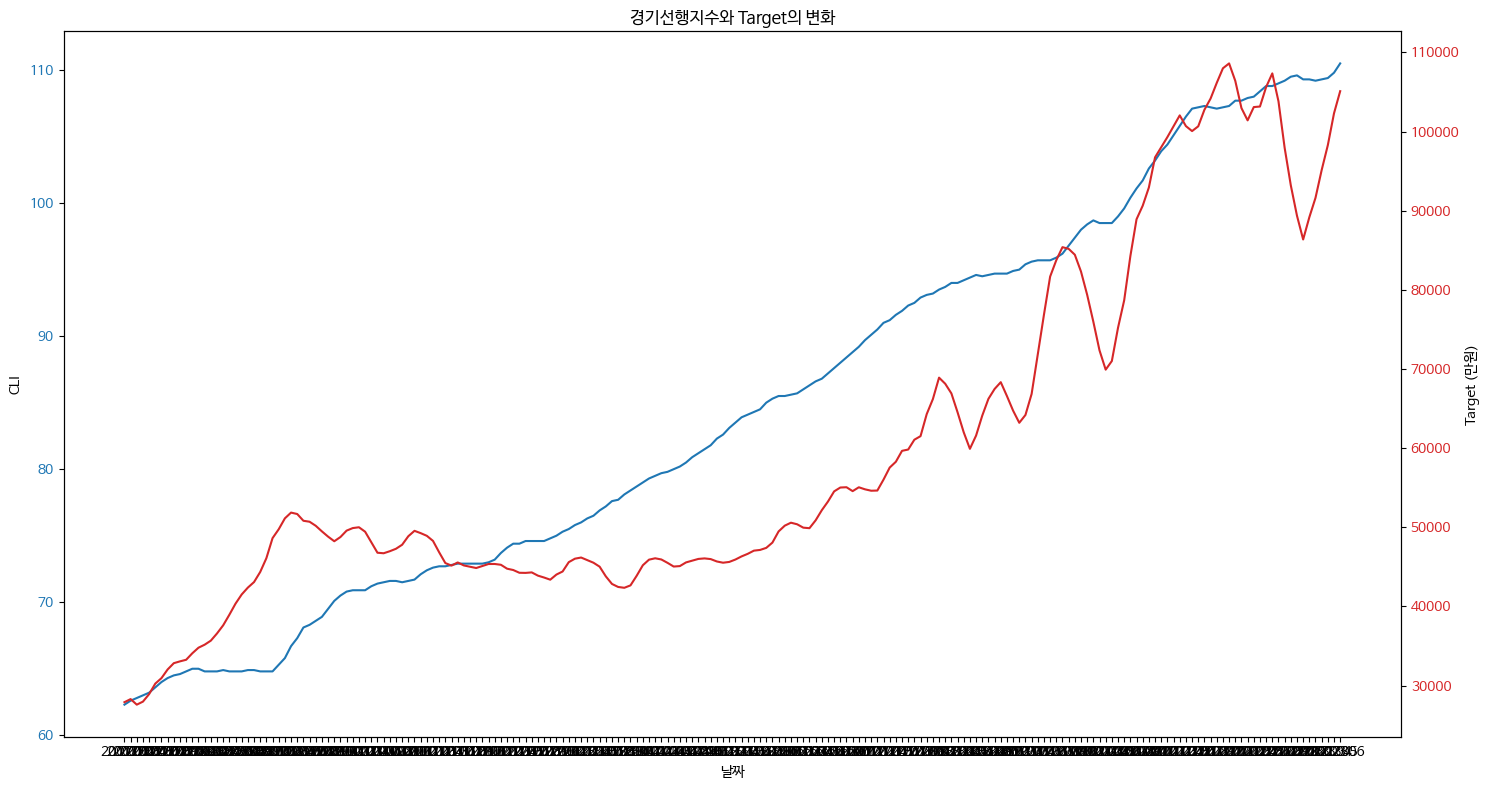

In [ ]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(15, 8))

# CLI를 첫 번째 축에 표시
ax1.plot(grouped_data['계약년월'], grouped_data['CLI'], color='tab:blue', label='CLI')
ax1.set_xlabel('날짜')
ax1.set_ylabel('CLI')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# target을 두 번째 축에 표시
ax2 = ax1.twinx()
ax2.plot(grouped_data['계약년월'], grouped_data['target_이동평균'], color='tab:red', label='target')
ax2.set_ylabel('Target (만원)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('경기선행지수와 Target의 변화')
plt.xticks(rotation=0)
fig.tight_layout()
plt.show()

In [ ]:
grouped_data.head(30)

,date,target,기준금리,기준금리_이동평균,target_이동평균
0,20070101,31585.714286,4.5,4.5,31585.714286
1,20070102,28994.780749,4.5,4.5,30290.247517
2,20070103,29248.859903,4.5,4.5,29943.118313
3,20070104,31458.057592,4.5,4.5,30321.853132
4,20070105,28689.483696,4.5,4.5,29995.379245
5,20070106,24604.091503,4.5,4.5,29096.831288
6,20070107,26142.307692,4.5,4.5,28674.756489
7,20070108,25519.489796,4.5,4.5,28280.348152
8,20070109,25781.423529,4.5,4.5,28002.689861
9,20070110,29598.171103,4.5,4.5,28162.237985


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [ ]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [ ]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [ ]:
concat['아파트명'].value_counts()

현대               16779
신동아              12929
한신                9128
두산                8593
주공2               7955
                 ...  
제니스뷰                 1
다온숲                  1
포렛빌                  1
DMC금호리첸시아            1
힐스테이트세운센트럴1단지        1
Name: 아파트명, Length: 6549, dtype: int64

In [ ]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})